# Plot 2d histograms from quadrant analysis
## Plot multiple simulations at same height z/h

In [1]:
%matplotlib inline
# import functions from python directory
import sys
sys.path.append("../python")
import os
import seaborn
import numpy as np
import xarray as xr
from scipy.stats import gmean
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESnc import load_stats

In [2]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
cmaps = [plt.get_cmap("Greys"), plt.get_cmap("Blues"), plt.get_cmap("Reds"), plt.get_cmap("Purples")]
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)

In [3]:
# directories
# figure save
figdir = "/home/bgreene/SBL_LES/figures/quadrant/"
# list of simulations to loop over
sims = ["cr0.10_u08", "cr0.25_u08", "cr0.33_u08", "cr0.50_u08", 
        "cr0.10_u01", "cr0.25_u01"]
# empty list to construct paths and store
dnc_all = []
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}_192/output/netcdf/"
    dnc_all.append(dnc)


In [4]:
# loop over sims and load stats and quadrant data
sall = []
qall = []
quadall = []
for dnc in dnc_all:
    # load stats file
    s = load_stats(dnc+"average_statistics.nc")
    sall.append(s)
    # load data for 2d histogram
    q = xr.load_dataset(dnc+"u_w_theta_2d_quadrant.nc")
    qall.append(q)
    # load quadrant files
    quad = xr.load_dataset(dnc+"uw_tw_quadrant.nc")
    quadall.append(quad)

Reading file: /home/bgreene/simulations/cr0.10_u08_192/output/netcdf/average_statistics.nc


/home/bgreene/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.33_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.10_u01_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.25_u01_192/output/netcdf/average_statistics.nc


## Determine joint distributions
### u' - w'

In [5]:
# initialize dictionary to store heights and simulations
H_uw_all = {}
# use same bins for each sim
uw_bins = (np.arange(-10., 10.1, 0.1), np.arange(-10., 10.1, 0.1))
# calculate bin area for normalizing later
uw_bin_area = np.diff(uw_bins[0])[0] * np.diff(uw_bins[1])[0]
# loop over heights and sims
for iz, sz in enumerate(np.around(qall[0].zh, 1)):
    sz = str(sz.values)
    H_uw_all[sz] = []
    for s, q in zip(sall, qall):
        # calculate bins and edges
        H_uw, x_uw, y_uw = np.histogram2d(q.u[iz].values/s.ustar0.values, 
                                          q.w[iz].values/s.ustar0.values, 
                                          bins=uw_bins, density=True)
        # normalize sum==1 by multiplying by bin area
        # also multiply by 100% for units
        H_uw *= uw_bin_area * 100.
        # append to big list
        H_uw_all[sz].append(H_uw)
# calculate bin centers
x1 = x_uw[:-1] + np.diff(x_uw)/2
y1 = y_uw[:-1] + np.diff(y_uw)/2

### Plot u' - w' joint dist
Subplots for each simulation and height

[Text(0.5, 1.0, '$h/L = {1.11}$'),
 Text(0.5, 1.0, '$h/L = {2.10}$'),
 Text(0.5, 1.0, '$h/L = {2.75}$'),
 Text(0.5, 1.0, '$h/L = {3.96}$'),
 Text(0.5, 1.0, '$h/L = {8.26}$'),
 Text(0.5, 1.0, '$h/L = {21.24}$')]

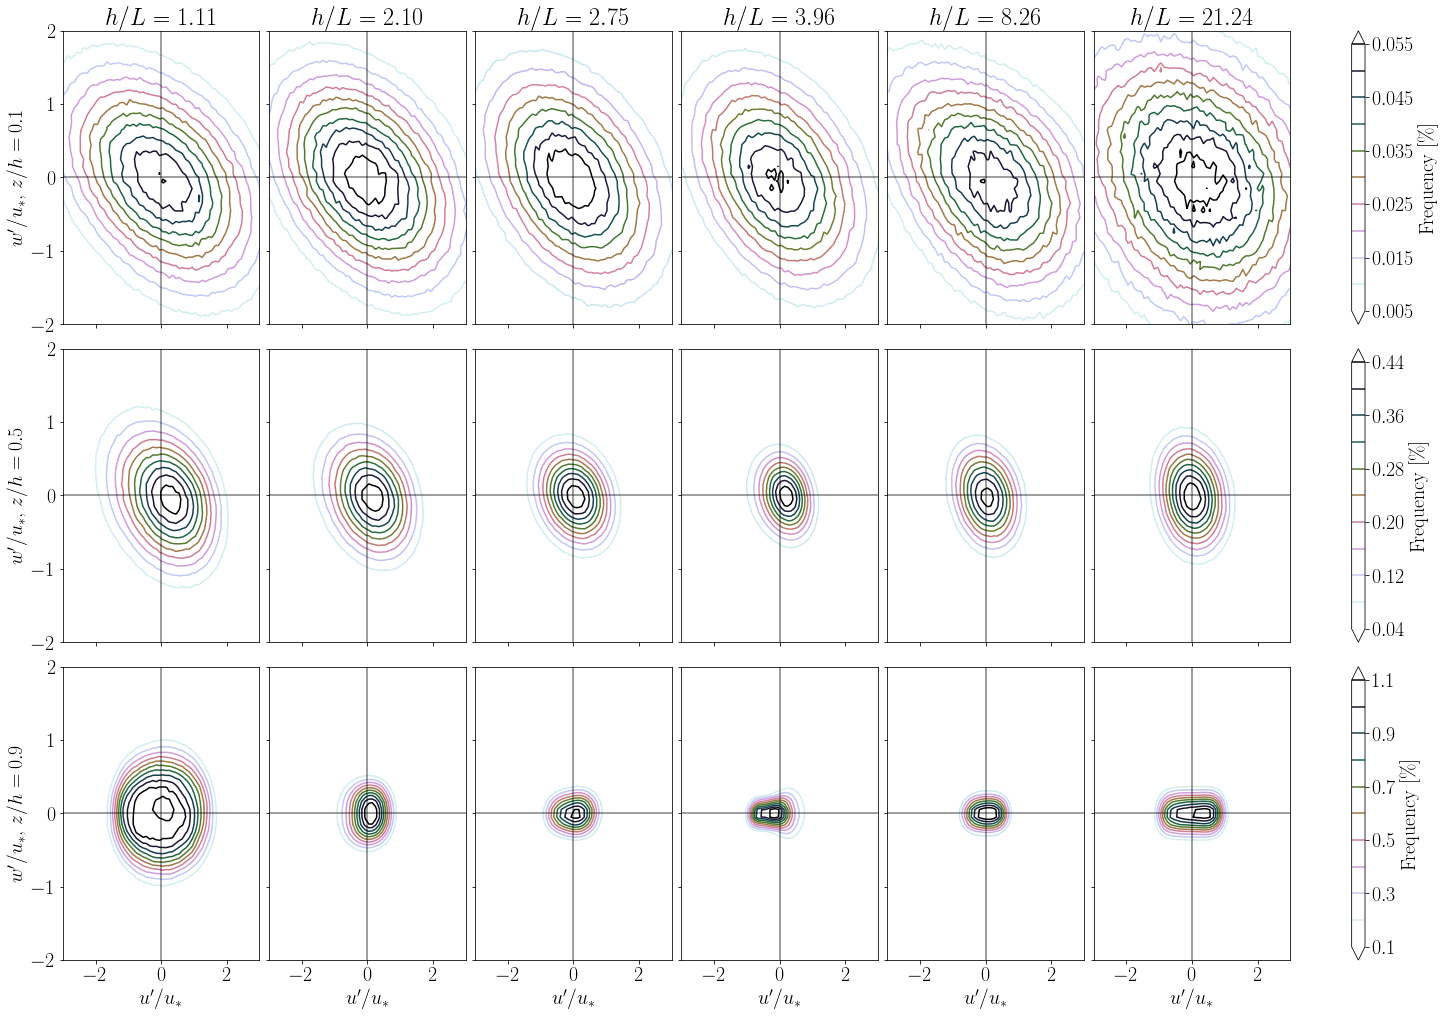

In [6]:
fig1, ax1 = plt.subplots(nrows=len(H_uw_all), ncols=len(qall), 
                         sharex=True, sharey=True, figsize=(20, 14), 
                         constrained_layout=True)
# loop over H_uw_all and contour -- keys(height) and list elements(simulation)
# loop over heights (rows)
for iH, sH in enumerate(H_uw_all.keys()):
    # determine contour levels at each height
    # levels = get_contour_levels(H_uw_all[sH], 21)
    cax1 = []
    # loop over simulations (columns)
    for isim, sim in enumerate(H_uw_all[sH]):
        cax = ax1[iH,isim].contour(x1, y1, H_uw_all[sH][isim].T, cmap=cmap2,
                                   extend="both", levels=11)
        # ax1[iH,isim].clabel(cax, cax.levels, inline=True, fontsize=10)                           
        cax1.append(cax)
    # add colorbars at end of rows
    cb1 = fig1.colorbar(cax1[-1], ax=ax1[iH,:], location="right")
    cb1.ax.set_ylabel("Frequency [\\%]")

# add labels
[iax.set_xlabel("$u'/u_{*}$") for iax in ax1[-1,:]]
[iax.set_ylabel(f"$w'/u_{{*}}$, $z/h={{{sH}}}$") for sH, iax in zip(H_uw_all.keys(), ax1[:,0])]
ax1[0,0].set_xlim([-3, 3])
ax1[0,0].set_ylim([-2, 2])
[iax.axhline(0., c="k", alpha=0.5) for iax in ax1.flatten()]
[iax.axvline(0., c="k", alpha=0.5) for iax in ax1.flatten()]
[iax.set_title(f"$h/L = {{{(sall[i].he/sall[i].L).values:3.2f}}}$") for i, iax in enumerate(ax1[0, :])]

### $\theta'$ - $w'$

In [7]:
# initialize dictionary to store heights and simulations
H_tw_all = {}
# use same bins for each sim
tw_bins = (np.arange(-15., 15.1, 0.1), np.arange(-10., 10.1, 0.1))
# calculate bin area for normalizing later
tw_bin_area = np.diff(tw_bins[0])[0] * np.diff(tw_bins[1])[0]
# loop over heights and sims
for iz, sz in enumerate(np.around(qall[0].zh, 1)):
    sz = str(sz.values)
    H_tw_all[sz] = []
    for s, q in zip(sall, qall):
        # calculate bins and edges
        H_tw, x_tw, y_tw = np.histogram2d(q.theta[iz].values/s.tstar0.values, 
                                          q.w[iz].values/s.ustar0.values, 
                                          bins=tw_bins, density=True)
        # normalize sum==1 by multiplying by bin area
        # also multiply by 100% for units
        H_tw *= tw_bin_area * 100.
        # append to big list
        H_tw_all[sz].append(H_tw)
# calculate bin centers
x2 = x_tw[:-1] + np.diff(x_tw)/2
y2 = y_tw[:-1] + np.diff(y_tw)/2

### Plot $\theta'$ - $w'$ joint

[Text(0.5, 1.0, '$h/L = {1.11}$'),
 Text(0.5, 1.0, '$h/L = {2.10}$'),
 Text(0.5, 1.0, '$h/L = {2.75}$'),
 Text(0.5, 1.0, '$h/L = {3.96}$'),
 Text(0.5, 1.0, '$h/L = {8.26}$'),
 Text(0.5, 1.0, '$h/L = {21.24}$')]

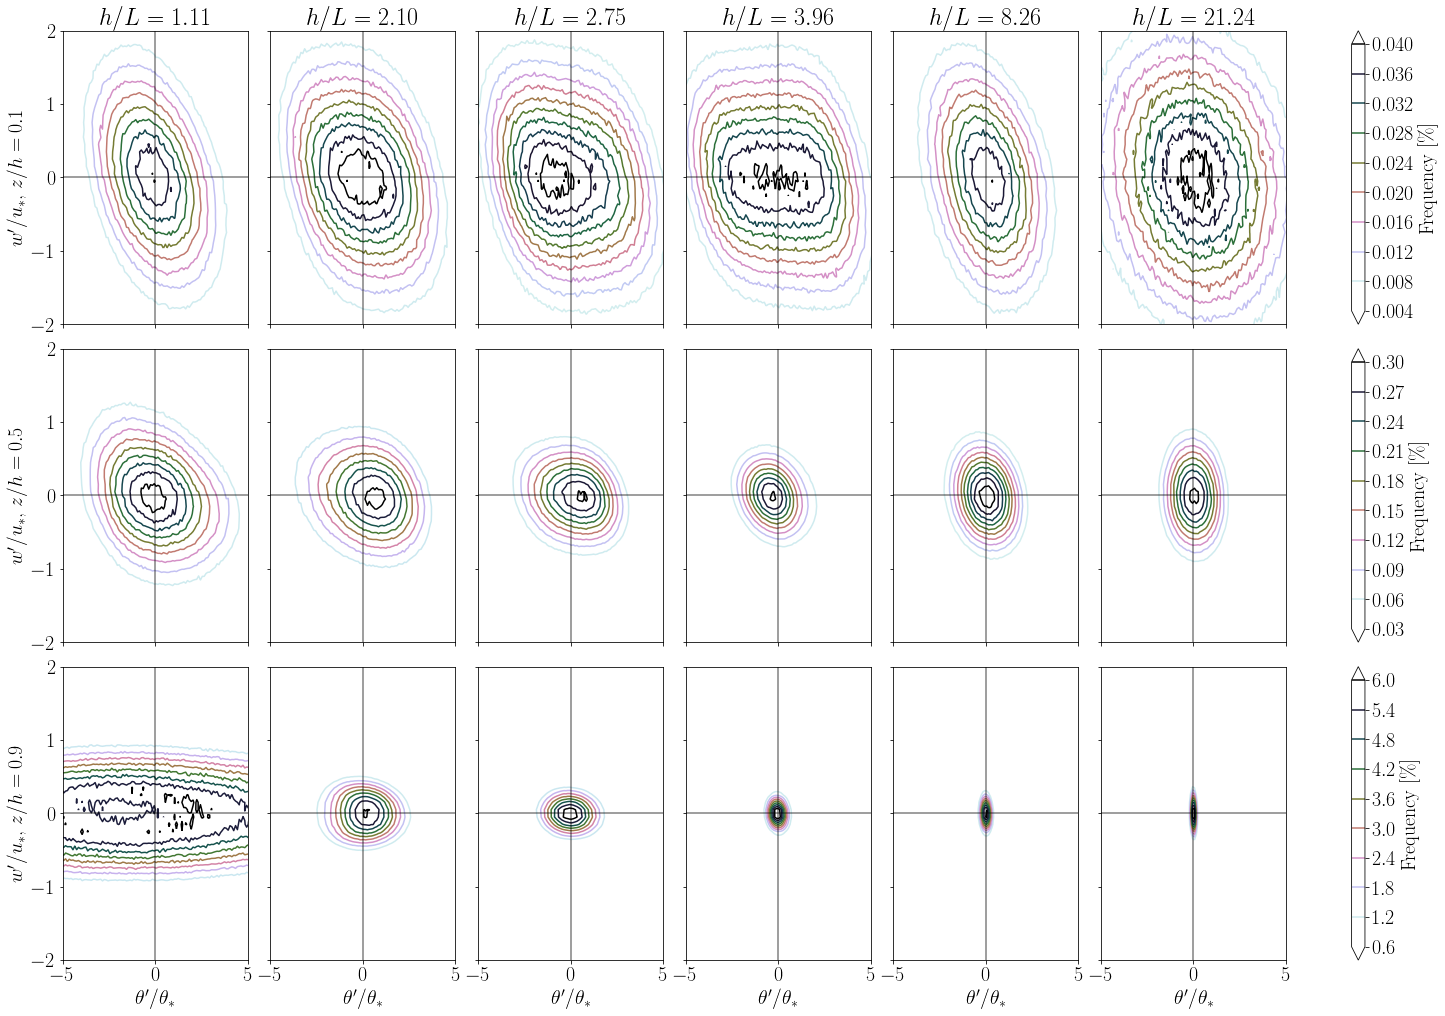

In [8]:
fig2, ax2 = plt.subplots(nrows=len(H_tw_all), ncols=len(qall), 
                         sharex=True, sharey=True, figsize=(20, 14), 
                         constrained_layout=True)
# loop over H_uw_all and contour -- keys(height) and list elements(simulation)
# loop over heights (rows)
for iH, sH in enumerate(H_tw_all.keys()):
    cax2 = []
    # loop over simulations (columns)
    for isim, sim in enumerate(H_tw_all[sH]):
        cax = ax2[iH,isim].contour(x2, y2, H_tw_all[sH][isim].T, cmap=cmap2,
                                   extend="both", levels=11)
        # ax1[iH,isim].clabel(cax, cax.levels, inline=True, fontsize=10)                           
        cax2.append(cax)
    # add colorbars at end of rows
    cb2 = fig2.colorbar(cax2[-1], ax=ax2[iH,:], location="right")
    cb2.ax.set_ylabel("Frequency [\\%]")

# add labels
[iax.set_xlabel("$\\theta'/\\theta_{*}$") for iax in ax2[-1,:]]
[iax.set_ylabel(f"$w'/u_{{*}}$, $z/h={{{sH}}}$") for sH, iax in zip(H_tw_all.keys(), ax2[:,0])]
ax2[0,0].set_xlim([-5, 5])
ax2[0,0].set_ylim([-2, 2])
[iax.axhline(0., c="k", alpha=0.5) for iax in ax2.flatten()]
[iax.axvline(0., c="k", alpha=0.5) for iax in ax2.flatten()]
[iax.set_title(f"$h/L = {{{(sall[i].he/sall[i].L).values:3.2f}}}$") for i, iax in enumerate(ax2[0, :])]

### $\theta'$ - $u'$

In [9]:
# initialize dictionary to store heights and simulations
H_tu_all = {}
# use same bins for each sim
tu_bins = (np.arange(-15., 15.1, 0.1), np.arange(-10., 10.1, 0.1))
# calculate bin area for normalizing later
tu_bin_area = np.diff(tu_bins[0])[0] * np.diff(tu_bins[1])[0]
# loop over heights and sims
for iz, sz in enumerate(np.around(qall[0].zh, 1)):
    sz = str(sz.values)
    H_tu_all[sz] = []
    for s, q in zip(sall, qall):
        # calculate bins and edges
        H_tu, x_tu, y_tu = np.histogram2d(q.theta[iz].values/s.tstar0.values, 
                                          q.u[iz].values/s.ustar0.values, 
                                          bins=tu_bins, density=True)
        # normalize sum==1 by multiplying by bin area
        # also multiply by 100% for units
        H_tu *= tu_bin_area * 100.
        # append to big list
        H_tu_all[sz].append(H_tu)
# calculate bin centers
x3 = x_tu[:-1] + np.diff(x_tu)/2
y3 = y_tu[:-1] + np.diff(y_tu)/2

[Text(0.5, 1.0, '$h/L = {1.11}$'),
 Text(0.5, 1.0, '$h/L = {2.10}$'),
 Text(0.5, 1.0, '$h/L = {2.75}$'),
 Text(0.5, 1.0, '$h/L = {3.96}$'),
 Text(0.5, 1.0, '$h/L = {8.26}$'),
 Text(0.5, 1.0, '$h/L = {21.24}$')]

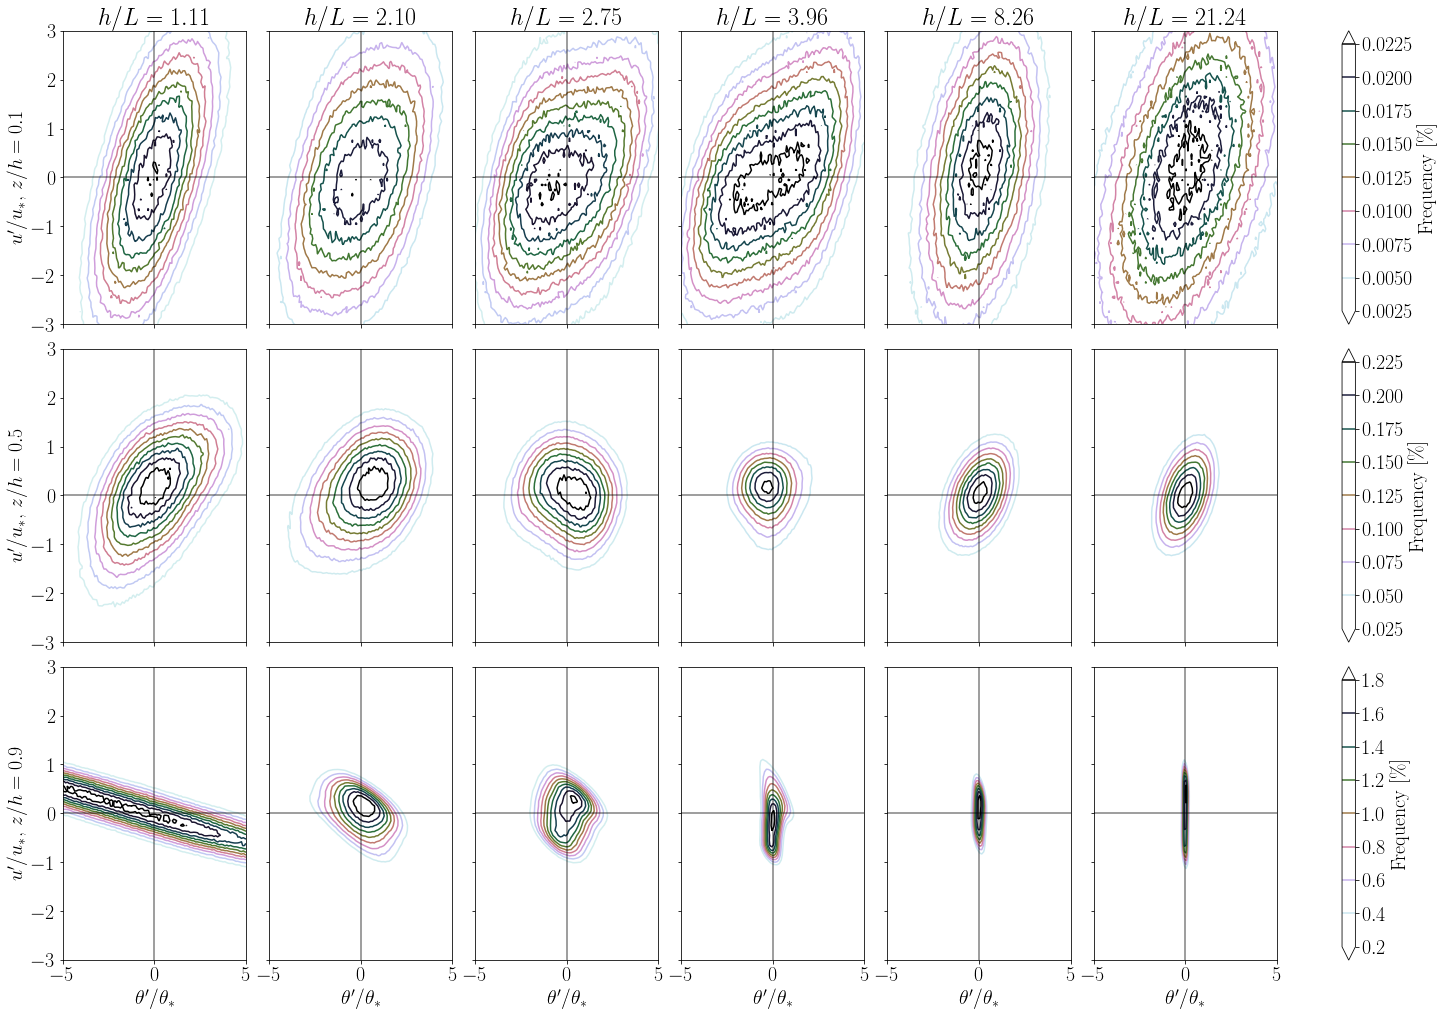

In [10]:
fig3, ax3 = plt.subplots(nrows=len(H_tu_all), ncols=len(qall), 
                         sharex=True, sharey=True, figsize=(20, 14), 
                         constrained_layout=True)
# loop over H_uw_all and contour -- keys(height) and list elements(simulation)
# loop over heights (rows)
for iH, sH in enumerate(H_tu_all.keys()):
    cax3 = []
    # loop over simulations (columns)
    for isim, sim in enumerate(H_tu_all[sH]):
        cax = ax3[iH,isim].contour(x3, y3, H_tu_all[sH][isim].T, cmap=cmap2,
                                   extend="both", levels=11)
        # ax1[iH,isim].clabel(cax, cax.levels, inline=True, fontsize=10)                           
        cax3.append(cax)
    # add colorbars at end of rows
    cb3 = fig2.colorbar(cax3[-1], ax=ax3[iH,:], location="right")
    cb3.ax.set_ylabel("Frequency [\\%]")

# add labels
[iax.set_xlabel("$\\theta'/\\theta_{*}$") for iax in ax3[-1,:]]
[iax.set_ylabel(f"$u'/u_{{*}}$, $z/h={{{sH}}}$") for sH, iax in zip(H_tu_all.keys(), ax3[:,0])]
ax3[0,0].set_xlim([-5, 5])
ax3[0,0].set_ylim([-3, 3])
[iax.axhline(0., c="k", alpha=0.5) for iax in ax3.flatten()]
[iax.axvline(0., c="k", alpha=0.5) for iax in ax3.flatten()]
[iax.set_title(f"$h/L = {{{(sall[i].he/sall[i].L).values:3.2f}}}$") for i, iax in enumerate(ax3[0, :])]

# Plot profiles of correlation coefficients $R_{uw}, R_{\theta w}, R_{\theta u}$

In [11]:
# loop over simulations
for s, quad in zip(sall, quadall):
    # R_ab = <a'b'> / (sigma_a * sigma_b)
    s["Ruw"] = np.abs(s.uw_cov_tot / np.sqrt(s.u_var) / np.sqrt(s.w_var))
    s["Rtw"] = np.abs(s.tw_cov_tot / np.sqrt(s.theta_var) / np.sqrt(s.w_var))
    # eta_uw = <u'w'> / (u-w+ + u+w-)
    s["eta_uw"] = np.abs(s.uw_cov_tot) / np.abs((quad.uw_np + quad.uw_pn))
    # eta_tw = <theta'w'> / (t+w+ + t-w-)
    s["eta_tw"] = np.abs(s.tw_cov_tot) / np.abs((quad.tw_pp + quad.tw_nn))

Text(0.5, 0, '$\\eta_{uw} / \\eta_{\\theta w}$')

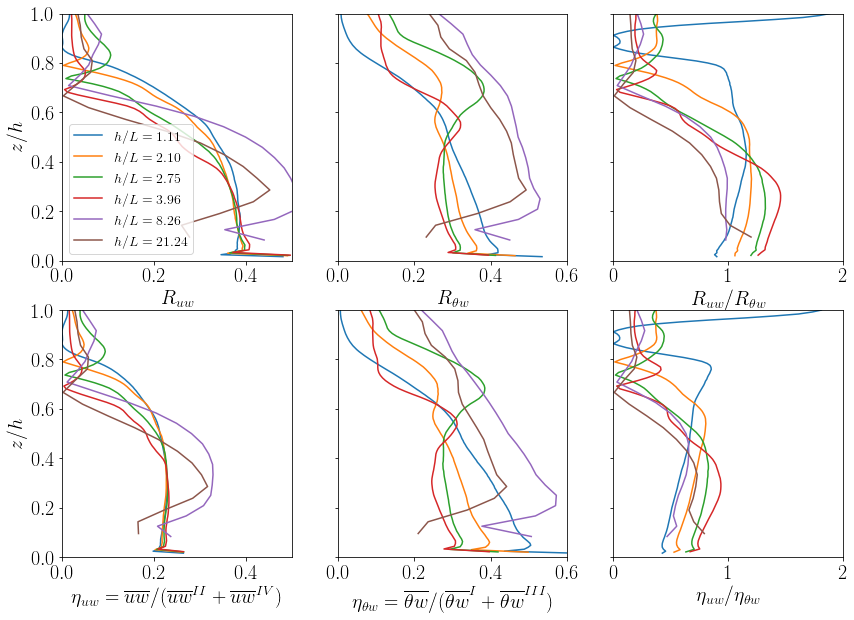

In [12]:
fig4, ax4 = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(14,10))
for s in sall:
    # Ruw
    ax4[0,0].plot(s.Ruw, s.z/s.he, label=f"$h/L={{{(s.he/s.L).values:3.2f}}}$")
    # Rtw
    ax4[0,1].plot(s.Rtw, s.z/s.he)
    # Ruw / Rtw
    ax4[0,2].plot(s.Ruw/s.Rtw, s.z/s.he)
    # eta_uw
    ax4[1,0].plot(s.eta_uw, s.z/s.he)
    # eta_tw
    ax4[1,1].plot(s.eta_tw, s.z/s.he)
    # eta_uw/eta_tw
    ax4[1,2].plot(s.eta_uw/s.eta_tw, s.z/s.he)

ax4[0,0].legend(fontsize=14)
ax4[0,0].set_xlim([0, 0.5])
ax4[1,0].set_xlim([0, 0.5])
ax4[0,1].set_xlim([0, 0.6])
ax4[1,1].set_xlim([0, 0.6])
ax4[0,2].set_xlim([0, 2])
ax4[1,2].set_xlim([0, 2])
ax4[1,0].set_ylim([0, 1])
ax4[0,0].set_xlabel("$R_{uw}$")
ax4[0,0].set_ylabel("$z/h$")
ax4[1,0].set_ylabel("$z/h$")
ax4[0,1].set_xlabel("$R_{\\theta w}$")
ax4[0,2].set_xlabel("$R_{uw}/R_{\\theta w}$")
ax4[1,0].set_xlabel("$\\eta_{uw} = \\overline{uw} / (\\overline{uw}^{II} + \\overline{uw}^{IV})$")
ax4[1,1].set_xlabel("$\\eta_{\\theta w} = \\overline{\\theta w} / (\\overline{\\theta w}^{I} + \\overline{\\theta w}^{III})$")
ax4[1,2].set_xlabel("$\\eta_{uw} / \\eta_{\\theta w}$")

In [13]:
quad

<xarray.Dataset>
Dimensions:  (z: 192)
Coordinates:
  * z        (z) float64 2.083 4.156 6.228 8.301 ... 391.7 393.8 395.8 397.9
Data variables:
    uw_pp    (z) float64 nan 0.001442 0.001369 ... 3.894e-06 3.169e-06 2.051e-06
    uw_pn    (z) float64 nan -0.002102 -0.001938 ... -3.09e-06 -2.027e-06
    uw_np    (z) float64 nan -0.002632 -0.002358 ... -3.303e-06 -2.105e-06
    uw_nn    (z) float64 nan 0.001497 0.001464 ... 4.065e-06 3.351e-06 2.163e-06
    tw_pp    (z) float64 nan 0.002254 0.001884 ... 1.797e-06 9.301e-07 3.351e-07
    tw_pn    (z) float64 nan -0.002865 -0.002483 ... -1.012e-06 -3.303e-07
    tw_np    (z) float64 nan -0.003116 -0.002667 ... -9.723e-07 -3.199e-07
    tw_nn    (z) float64 nan 0.002322 0.001926 ... 1.864e-06 8.872e-07 3.293e-07
Attributes:
    nx:         192
    ny:         192
    nz:         192
    Lx:         800.0
    Ly:         800.0
    Lz:         400.0
    dx:         4.166666666666667
    dy:         4.166666666666667
    dz:         2.0833333333333335
    stability:  cr0.25_u01_192
    delta:      3.3070855249337487
    tavg:       1h

# Profiles of quadrant fractions

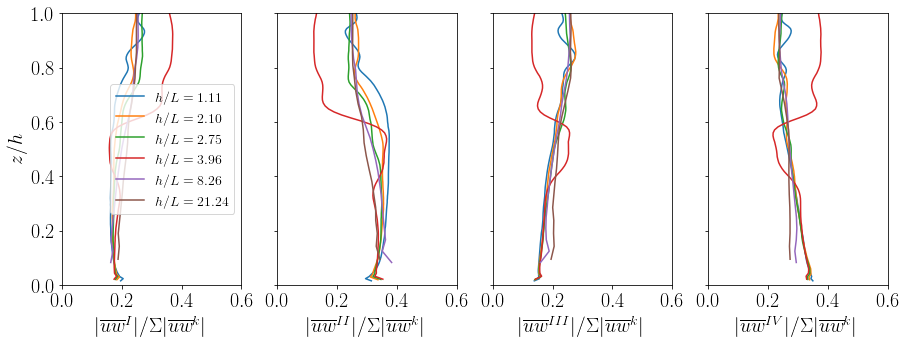

In [14]:
# u'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 5))
# loop over simulations
for s, quad in zip(sall, quadall):
    # calc sum of quadrants -- NOTE: not weighted average!
    quad["uw_sum"] = np.abs(quad.uw_pp) + np.abs(quad.uw_pn) + np.abs(quad.uw_np) + np.abs(quad.uw_nn)
    # quadrant I: u+w+
    ax5[0].plot(np.abs(quad.uw_pp)/np.abs(quad.uw_sum), s.z/s.he, 
                label=f"$h/L={{{(s.he/s.L).values:3.2f}}}$")
    # quadrant II: u-w+
    ax5[1].plot(np.abs(quad.uw_np)/np.abs(quad.uw_sum), s.z/s.he)
    # quadrant III: u-w-
    ax5[2].plot(np.abs(quad.uw_nn)/np.abs(quad.uw_sum), s.z/s.he)
    # quadrant II: u+w-
    ax5[3].plot(np.abs(quad.uw_pn)/np.abs(quad.uw_sum), s.z/s.he)
# clean up
ax5[0].legend(fontsize=14)
ax5[0].set_ylim([0, 1])
ax5[0].set_ylabel("$z/h$")
ax5[0].set_xlim([0, 0.6])
[iax.set_xlabel(f"$|\\overline{{uw}}^{{{ii}}}| / \\Sigma | \\overline{{uw}}^k |$") for iax, ii in zip(ax5, ["I", "II", "III", "IV"])]
ax5[0].xaxis.set_major_locator(MultipleLocator(0.2))

# Transport efficiencies versus $z/Ls$

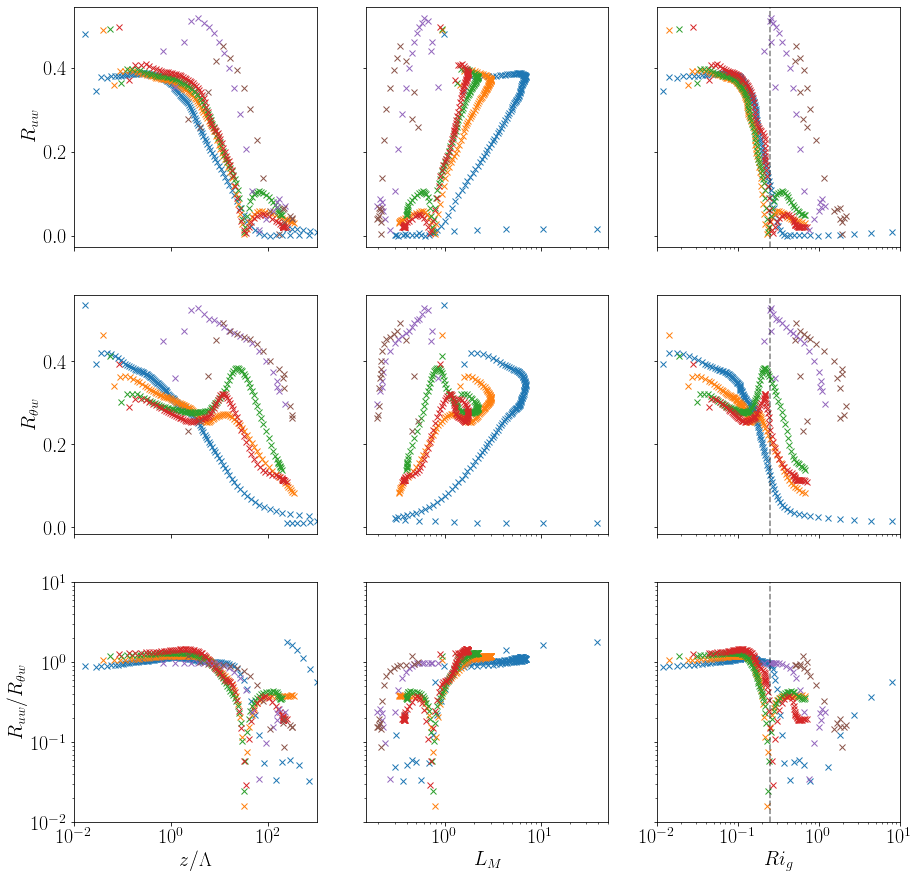

In [15]:
fig6, ax6 = plt.subplots(nrows=3, ncols=3, sharex="col", sharey="row", figsize=(14.8, 15))
for s in sall:
    isbl = np.where(s.z < s.he)[0]
    # plot versus z/Lambda
    # Ruw
    ax6[0,0].plot(s.z[isbl]/s.LL, s.Ruw[isbl], "x")
    # Rtw
    ax6[1,0].plot(s.z[isbl]/s.LL, s.Rtw[isbl], "x")
    # Ruw / Rtw
    ax6[2,0].plot(s.z[isbl]/s.LL, s.Ruw[isbl]/s.Rtw[isbl], "x")
    # plot versus something
    # calculate LM = ustar / dudz
    s["LM"] = s.ustar[isbl] / s.du_dz[isbl]
    # calculate stress intensity ratio c^2
    s["c2"] = s.ustar2[isbl]/s.e
    # Ruw
    ax6[0,1].plot(s.LM[isbl], s.Ruw[isbl], "x")
    # Rtw
    ax6[1,1].plot(s.LM[isbl], s.Rtw[isbl], "x")
    # Ruw / Rtw
    ax6[2,1].plot(s.LM[isbl], s.Ruw[isbl]/s.Rtw[isbl], "x")
    # plot versus Ri
    # Ruw
    ax6[0,2].plot(s.Rig[isbl], s.Ruw[isbl], "x")
    # Rtw
    ax6[1,2].plot(s.Rig[isbl], s.Rtw[isbl], "x")
    # Ruw / Rtw
    ax6[2,2].plot(s.Rig[isbl], s.Ruw[isbl]/s.Rtw[isbl], "x")

ax6[0,0].set_xscale("log")
ax6[0,0].set_xlim([1e-2, 1e3])
ax6[0,0].set_ylabel("$R_{uw}$")
ax6[1,0].set_xscale("log")
ax6[1,0].set_xlim([1e-2, 1e3])
ax6[1,0].set_ylabel("$R_{\\theta w}$")
ax6[2,0].set_xlabel("$z/\\Lambda$")
ax6[2,0].set_ylabel("$R_{uw} / R_{\\theta w}$")
ax6[2,0].set_ylim([0.01, 10])
ax6[2,0].set_yscale("log")

ax6[2,1].set_xscale("log")
# ax6[2,1].set_xlim([1e-1, 1e1])
# ax6[2,1].set_xlabel("$L_s/\kappa z$")
ax6[2,1].set_xlabel("$L_M$")

ax6[2,2].set_xscale("log")
ax6[2,2].set_xlim([1e-2, 1e1])
ax6[2,2].set_xlabel("$Ri_g$")
for iax in ax6[:,2]:
    iax.axvline(0.25, c="k", ls="--", alpha=0.5)

In [24]:
ntot = 0
for s in sall:
    isbl = np.where(s.z <= s.he)[0]
    nsbl = len(isbl)
    ntot += nsbl
    print(f"nsbl = {nsbl}")
print(f"ntot = {ntot}")

nsbl = 125
nsbl = 100
nsbl = 95
nsbl = 91
nsbl = 24
nsbl = 21
ntot = 456


# Plot transport efficiencies as box and whisker plots versus Richardson number $Ri_g$

In [30]:
# Need to create bins
# strategy 1: logspace in Rig
# strategy 2: sort all points by Rig and plot bins of N points each

# start with strategy 1
# dump all values of Rig, Ruw, and Rtw into new 1d arrays to then sort by Rig
# initialize empty arrays
# first need to know how many points there are total in all sims
ntot = 0
for s in sall:
    isbl = np.where(s.z <= s.he)[0]
    nsbl = len(isbl)
    ntot += nsbl
# initialize empty arrays
Rig_all, Ruw_all, Rtw_all = [np.zeros((ntot), dtype=np.float64) for _ in range(3)]

# loop over arrays and store values into these new long arrays
count = 0
for s in sall:
    # only look within sbl
    isbl = np.where(s.z <= s.he)[0]
    # number of values for indexing
    nsbl = len(isbl)
    # assign
    Rig_all[count:count+nsbl] = s.Rig[isbl].values
    Ruw_all[count:count+nsbl] = s.Ruw[isbl].values
    Rtw_all[count:count+nsbl] = s.Rtw[isbl].values
    count += nsbl

/home/bgreene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [38]:
# now sort Rig_all
isort = np.argsort(Rig_all)
# new arrays with sorted values for further processing
Rig = Rig_all[isort]
Ruw = Ruw_all[isort]
Rtw = Rtw_all[isort]
# can also calculate ratio Ruwtw
Ruwtw = Ruw / Rtw

# define bin edges
Ribin = np.logspace(-2, 1, 31)
# calculate bin centers for plotting later
Ribin_mid = []
for iR in range(len(Ribin)-1):
    Ribin_mid.append(gmean([Ribin[iR], Ribin[iR+1]]))
Ribin_mid = np.array(Ribin_mid)

# define empty lists for storing binned data
Ruw_bin, Rtw_bin, Ruwtw_bin = [[] for _ in range(3)]
# loop over bins and store arrays
for iR in range(len(Ribin)-1):
    ibin = np.where((Rig > Ribin[iR]) & (Rig <= Ribin[iR+1]))[0]
    Ruw_bin.append(Ruw[ibin])
    Rtw_bin.append(Rtw[ibin])
    Ruwtw_bin.append(Ruwtw[ibin])

/home/bgreene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


/home/bgreene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/bgreene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/bgreene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


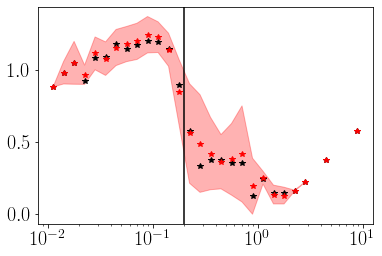

In [56]:
fig7, ax7 = plt.subplots(1)
stdlo = []
stdhi = []
for ib, bb in enumerate(Ruwtw_bin):
    ax7.plot(Ribin_mid[ib], np.nanmedian(bb), "*k")
    ax7.plot(Ribin_mid[ib], np.nanmean(bb), "*r")
    stdlo.append(np.nanmean(bb)-np.nanstd(bb))
    stdhi.append(np.nanmean(bb)+np.nanstd(bb))
ax7.fill_between(Ribin_mid, stdlo, stdhi, alpha=0.3, color="r")

ax7.set_xscale("log")
ax7.axvline(0.20, c="k")

/home/bgreene/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)
/home/bgreene/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe4b99dc810>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe4b99e70d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe4b99dc450>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe4b99e7990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4b99e7dd0>,
 'means': []}

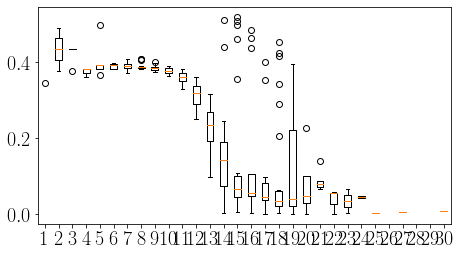

In [62]:
plt.subplots(1, figsize=(7.4, 4))
plt.boxplot(Ruw_bin)